In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

### CSCI 447 Fall 2023 Kaggle Competition

In [2]:
train = pd.read_csv('data/kaggle_train.csv')
test = pd.read_csv('data/kaggle_test.csv')
# example = pd.read_csv('data/kaggle_example_submission.csv')

In [3]:
train

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,target
0,1,0.777029,-0.268638,0.006591,2.941390,1.738013,1.672624,1.073224,-1.225081,2.700900,3.661704,6.567695,2.098585,-0.547649,0.523154,0.786378,0.104577,1.903580,-0.377440,-0.315180,-0.164134,-18.759727
1,2,1.203906,0.536988,0.476183,0.982111,1.737830,1.640134,0.302358,1.782921,1.442371,0.002198,0.144266,0.997498,0.856467,0.696694,0.628658,1.075109,2.234290,-0.388820,0.644219,0.724307,8.082223
2,3,0.751503,-0.036427,0.404269,0.143162,1.737872,1.680058,1.071646,1.263593,1.153890,0.232469,3.315893,1.511541,1.185047,0.269776,0.701282,1.041008,1.847635,1.163074,1.259852,0.548363,2.961315
3,4,0.669598,0.685746,0.328121,1.353119,1.737922,1.683888,-0.632106,0.140971,1.549584,2.136884,4.153014,2.043596,0.706472,0.925189,0.656511,0.524939,1.878676,2.755045,1.664802,0.453177,-0.710178
4,5,0.731188,-0.272476,0.375570,2.343038,1.737871,1.668550,1.747394,0.788427,2.094505,0.598815,-0.912722,0.446173,-1.051054,0.931456,0.949737,0.641303,1.958897,-2.146309,1.793418,1.107921,5.328069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,0.727128,0.659784,0.189603,0.871884,1.737953,1.663123,0.011820,0.455213,1.570676,1.601924,0.582432,0.018540,0.676099,0.238891,0.921408,0.435090,1.559085,1.253568,1.351787,-0.208061,-5.492524
396,397,0.721650,0.063371,0.104771,-0.304936,1.737823,1.669915,0.467188,-1.075683,1.027013,-0.815221,3.340801,0.594496,2.106144,0.472494,0.880513,0.661462,3.645808,-1.926029,2.298594,0.202313,-5.085613
397,398,0.643112,0.277107,0.299154,2.177613,1.737892,1.675028,0.328016,0.528663,2.316577,0.890271,0.011226,1.832636,0.469831,0.839231,0.810295,0.561670,2.142701,-0.266876,1.841052,0.240394,-0.515391
398,399,0.885107,0.162407,0.519112,-0.209804,1.737816,1.661044,0.467411,2.288113,0.937617,-0.443033,-0.200005,-0.743676,0.573866,0.867120,0.389433,0.442357,2.915442,0.157586,1.276146,0.688184,11.585216


In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#### XGBoost:

In [43]:
# split data into train and test sets
X = train.drop(['target'], axis=1)
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [44]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 17.9969000513692


In [10]:
# grid search on xgb
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2]
}
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
-15.549207292756998
MSE: 10.635793383780015


In [45]:
xgb_best_so_far = XGBRegressor(n_estimators=500, learning_rate=0.2, max_depth=1, min_child_weight=1, gamma=0.1, random_state=42)
xgb_best_so_far.fit(X_train, y_train)
y_pred = xgb_best_so_far.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 6.004979681667419


#### FEATURE ENGINEERING:

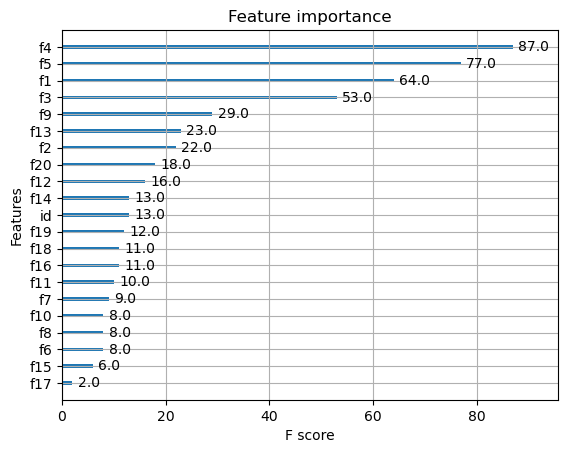

In [51]:
# find most important features
from xgboost import plot_importance
plot_importance(xgb_best_so_far)
plt.show()

In [58]:
cols_to_drop = ['f7', 'f10', 'f8', 'f6', 'f15', 'f17', 'f11', 'f16']
train_trimmed = train.drop(cols_to_drop, axis=1)

X = train_trimmed.drop(['target'], axis=1)
y = train_trimmed['target']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.5, random_state=42)
xgb_best_so_far.fit(X_train_new, y_train_new)
y_pred_new = xgb_best_so_far.predict(X_test_new)
mse = mean_squared_error(y_test_new, y_pred_new)
print('MSE trimmed dataset:', mse)

MSE trimmed dataset: 5.589545262288373
